# Exercise 4, clustering and data visualization

1) Read data files as “data_t-SNE_310101_d5_R100_e1_N800.dat” provided in the google 
    folder, which contain high dimensional data (d=5 in this case, with columns separated by the
    tab “\t”) with embedded manifolds as those in the figure, which represent three clusters with 
    a linear closed structure. Given N data points, the first 10% belongs to cluster “0” (red), the 
    next 30% to cluster “1” (green) and the last 60% to cluster “2” (blue). The green cluster is 
    linked to the blue one, in the 3d representation. This is expected to challenge the 
    convergence of t-SNE. The knotted structure of the blue cluster should introduce a similar 
    challenge to t-SNE, which tries to
    unfold the data in two dimensions.
    
2) Apply t-SNE with 4 different perplexities to the data. The method is one out of many 
    methods available at scikit website:
    https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
    
3) From NB15 extract the part concerning the DBSCAN algorithm for clustering and embed it 
    in the notebook to analyze the clustering in d=5 dimensions to generate predicted labels, 
    then plot the results. Something like the next figure should arise. It includes a grid with 
    several values of “eps” and “minPts”
    The figure specifies, for each panel, the corresponding value of “nmi” defined in the 
    notebook by Mehta et al, which quantifies the difference between true labels and predicted 
    ones.
    One needs to take care of introducing meaningful values of “eps” in DBSCAN: this 
    parameter is the radius of the spheres around points, and one needs spheres to be reasonably 
    full. In your notebook, find the typical scale separating points in d=5 from their first 
    neighbors, and use it as a reference for “eps”, trying some multiples of that value.
    
4) As usual, play with parameters. For instance, in t-SNE one may initialize the algorithm by 
    using principal component analysis (PCA). Also a 3D version of t-SNE could be used; it is 
    available in the packages.
    
    
-----
An interesting reading is given by this [distill post](https://distill.pub/2016/misread-tsne/) in which some tips are given in order to perform and inteprete correctly t-SNE.

See the [scikit-learn doc](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) for all the settings relative to t-SNE


Note that, after each running the result changes because the KL divergence is *not* a convex function. This cause to have different realization

## 1. Read data and apply default t-SDE in 3D

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets
import scipy as sp

In [70]:
file = 'DATA/data_t-SNE_310101_d5_R100_e1_N800.dat'
data = np.loadtxt(file, delimiter='\t', dtype=int)
n = data.shape[0]
print(f'n: {n}')

# Parameters for t-SNE
n_components = 3 # dimention of the enbedded space (the one in which data is projected)
perplexity = 35
learning_rate = 200 # for minimization, default:200
n_iter = 1500 # iterations, default:1000

tsne = manifold.TSNE(n_components = n_components,
                    perplexity = perplexity,
                    learning_rate = learning_rate,
                    n_iter = n_iter) 
X_embedded = tsne.fit_transform(data) # Let's perform t-SNE on data

n: 800


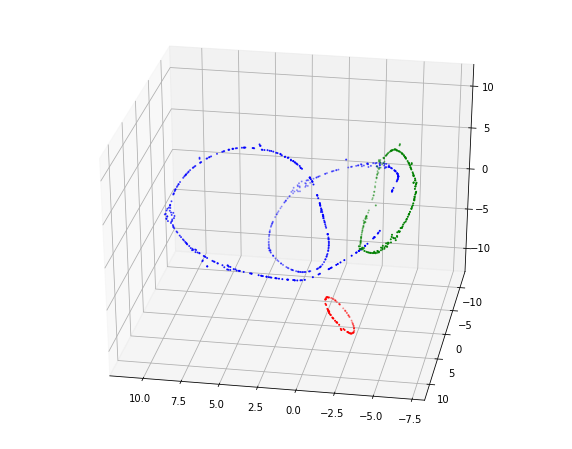

In [75]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,  projection='3d')

# Plotting data without distinguish between clusters
#ax.scatter(X_embedded[:,0],X_embedded[:,1],X_embedded[:,2], c="r")

# Plotting data distinguishing between clusters
first_cl = int(n*0.1)
second_cl = int(n*0.4)

ax.scatter(X_embedded[:first_cl,0], 
           X_embedded[:first_cl,1], 
           X_embedded[:first_cl,2], s=1, c="r")
ax.scatter(X_embedded[first_cl:second_cl,0], 
           X_embedded[first_cl:second_cl,1],
           X_embedded[first_cl:second_cl,2], s=1,c="g")
ax.scatter(X_embedded[second_cl:,0],
           X_embedded[second_cl:,1],
           X_embedded[second_cl:,2], s=1, c="b")

ax.view_init(30, 100)
plt.axis('tight');
plt.show()

Even if the image changes for each running, we noted that values for the `complexity` in the range $[30,40]$ give similar topologies and all are consistent with the one we expect to obtain. The number of `iteration` can be fixed above, the default, $1000$ because after that number of iteration the structure remain "stable".

## 2. Apply t-SNE in 2D with 4 different perplexities to the data

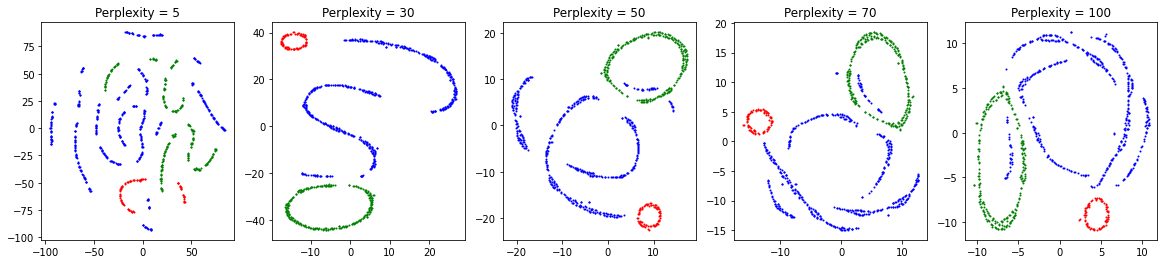

In [80]:
perplexities = [5, 30, 50, 70, 100]

(fig, subplots) = plt.subplots(1, 5, figsize=(20, 4))

for i, perplexity in enumerate(perplexities):

    tsne = manifold.TSNE(n_components=2,
                         perplexity=perplexity)
    X_embedded = tsne.fit_transform(data)
    
    ax = subplots[i]
    ax.set_title(f"Perplexity = {perplexity}")
    ax.scatter(X_embedded[:first_cl,0], X_embedded[:first_cl,1], s=1, c='r')
    ax.scatter(X_embedded[first_cl:second_cl,0], X_embedded[first_cl:second_cl,1], s=1, c="g")
    ax.scatter(X_embedded[second_cl:,0], X_embedded[second_cl:,1], s=1, c="b")
    ax.axis('tight')
    
plt.show()

## 3. DBSCAN algorithm

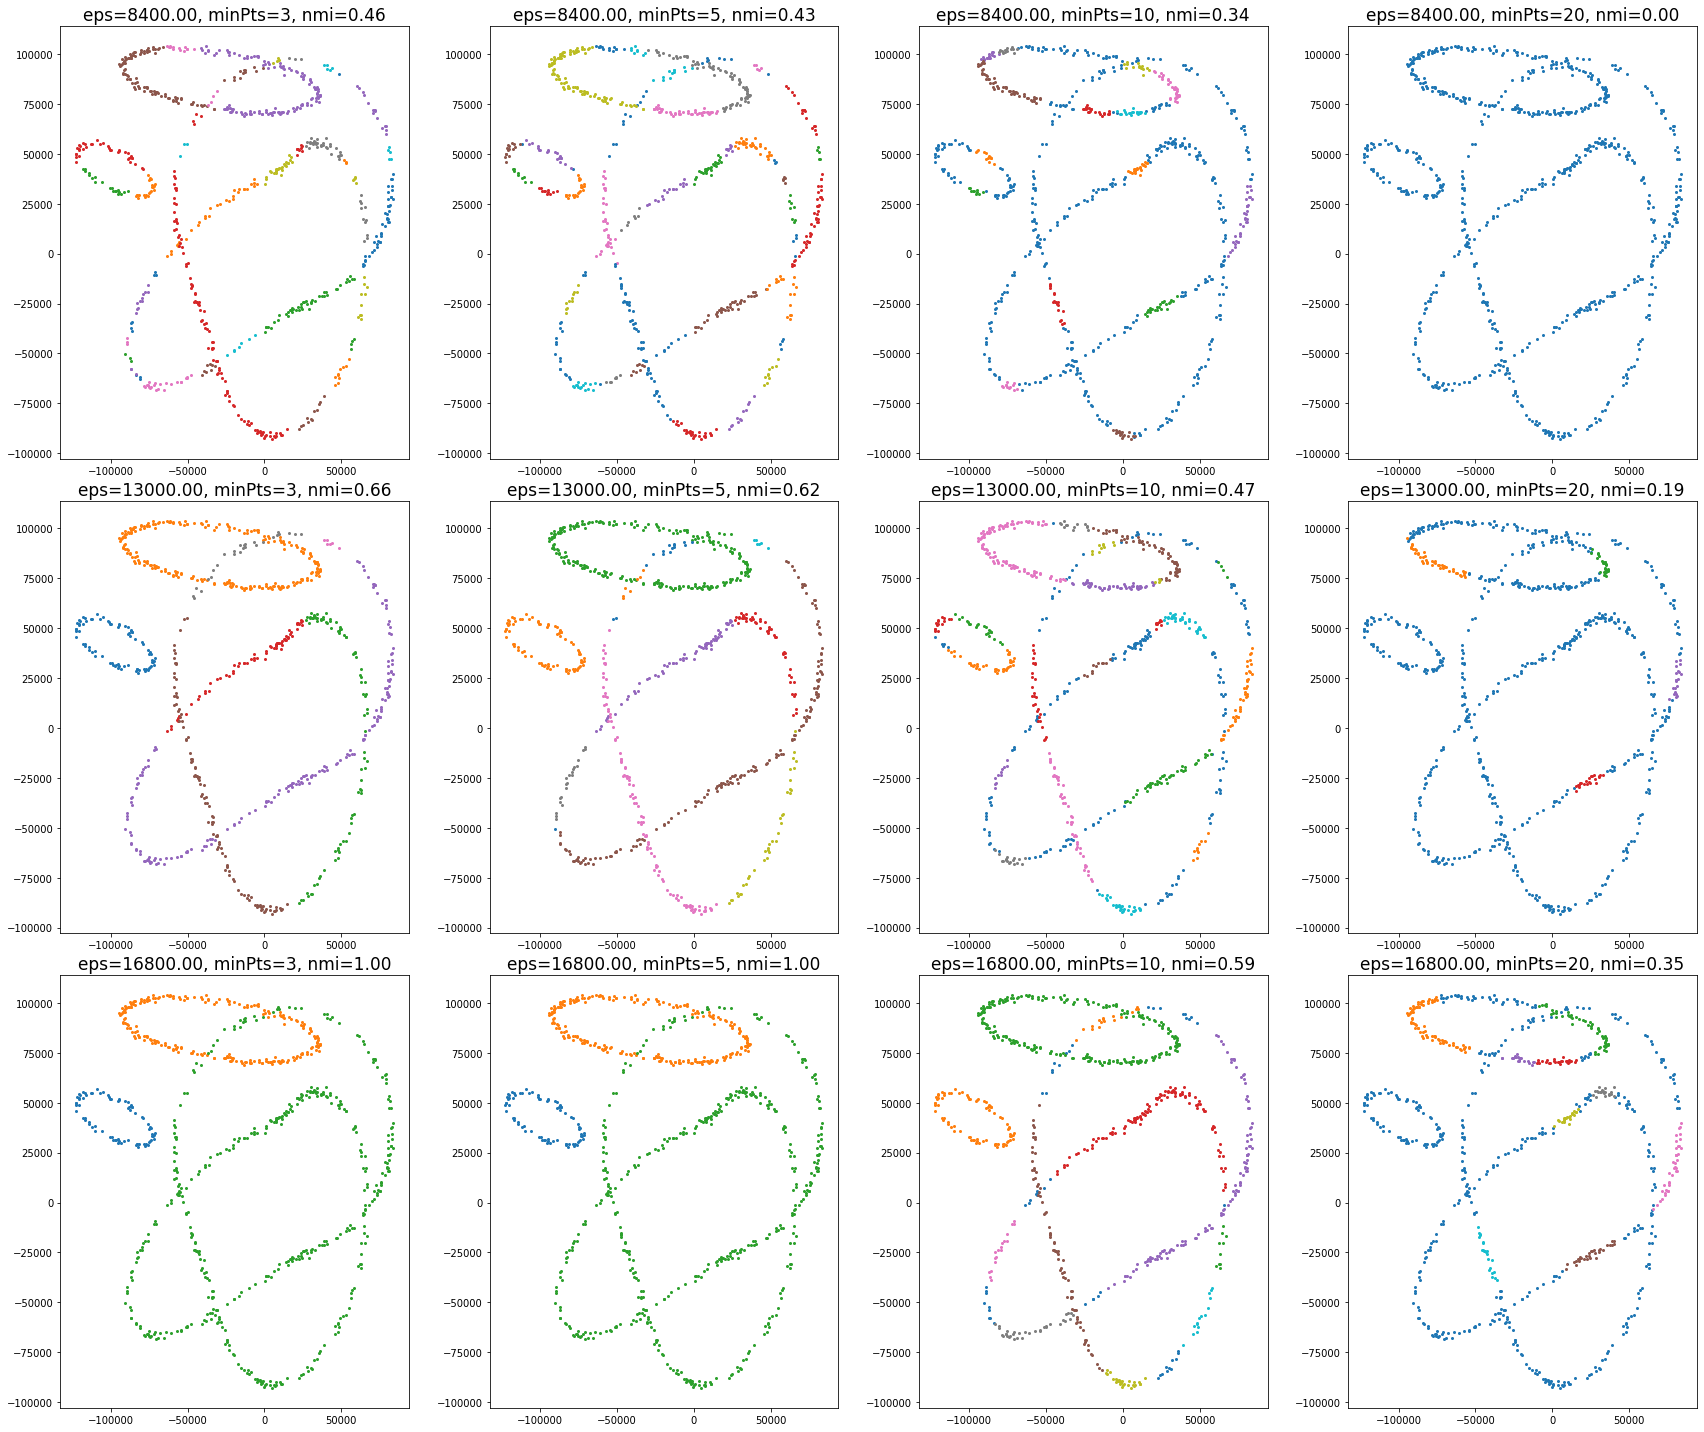

In [101]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

def plotting_ax(X, y, ax):
    ''' plotting function '''
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu) 
        # pos is a mask for take all
        # points which have label yu
        ax.scatter(X[pos,0], X[pos,1], s=4)

def clustering(y):
    ''' 
    Finds position of labels and returns a 
    dictionary of cluster labels to data indices. 
    '''
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    ''' Measures the entropy of a cluster '''
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    '''
    Computes normalized mutual information: 
    where y_true and y_pred are both clustering assignments
    '''
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)


# ------------------------------------- DBSCAN ---------------------------------------- #

eps = [8400, 13000, 16800]
min_sample = [3, 5, 10, 20]

# True labels
ytrue = np.repeat(1, n)
ytrue[first_cl:second_cl] = 2 # second cluster
ytrue[second_cl:] = 3 # third cluster

fig, ax = plt.subplots(3,4,figsize=(24, 20))

for i, e in enumerate(eps):
    for j, min_samples in enumerate(min_sample):
        
        model = DBSCAN(eps=e, min_samples=min_samples)
        model.fit(data)
        # return the labels, i.e. the cluster indecies, for
        # each point in data
        y = model.labels_         
        
        nmi = NMI(y, ytrue)
        
        plotting_ax(data, y , ax[i,j])
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(e , min_samples, nmi)
                         , fontsize = 17)
        
        
plt.tight_layout(h_pad=0.5)
plt.show()

For this particular dataset, seems that for value of `eps` greater than $16000$ and `minPts` less than $6$ we have a perfect match (`nmi` $=1$) between the real labels and the clustering method.